# Mangrove classification - v4f
#### Determining training samples

    ✅ Load Landsat data for 2016
    ✅ Calculate vegetation indices
    ✅ Establish mangrove threshold based on exploratory analysis
    ⬜ Remove inland water bodies
    ✅ Perform k-means classification
            ✅ Use Fractional Vegetation Cover or NDVI from previous year to distinguish open and closed forest dieback
    ✅ Select classes based on Duke's photos (this will be better when we collect ground truth data)

#### Classification (1987 - 2023)

    ✅ Train the model (include classification report and confusion matrix)
            ✅ Include optimal parameters analysis
    ✅ Perform the classification
            ✅ Improve thresholding (maybe use the same from k-means)
    ✅ Remove salt and pepper noise through majority filter
    ⬜ Classify the classes based on the NDVI (e.g. if class X NDVI > 0.6 => class X = Rhizophora)

#### Comparing the model

    ✅ Danaher 1999
    ✅ Duke 2016

#### Exporting data

    ✅ Export NDVI, NDWI, FVC, FPC, distance to water, and class of each pixel


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio
import rioxarray as rio
import seaborn as sns
import shapely.geometry
import sys
import xarray as xr
import datacube

from datacube import Datacube
from datacube.drivers.netcdf import write_dataset_to_netcdf
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from datetime import datetime
from dea_tools.bandindices import calculate_indices
from dea_tools.coastal import get_coastlines
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb
from matplotlib import colors
from rasterio.features import geometry_mask, rasterize
from scipy.ndimage import generic_filter
from scipy.ndimage import distance_transform_edt as distance_transform
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, calinski_harabasz_score, classification_report, cohen_kappa_score, confusion_matrix, silhouette_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

dc = datacube.Datacube()


# Preparing data for K-means classification

### Loading data

##### Landsat

In [5]:
query_ls = {
    'x': (139.659678, 139.949658),
    'y': (-17.515088, -17.805069),
    'time': ('2015', '2017'),
    'output_crs': 'EPSG:3577',
    'resolution': (-25, 25),
    'group_by': 'solar_day'
}

ds = load_ard(dc=dc, products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], min_gooddata=0.99, **query_ls)

# Resample Landsat data to get 2016
ls_resampled = ds.resample(time='1Y').median()
ls_2016 = ls_resampled.sel(time='2016')


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 24 out of 135 time steps with at least 99.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 24 time steps


KeyboardInterrupt: 

##### SRTM Elevation
###### Not using

In [ ]:
# # Elevation data
# query_elevation = {
#     'x': (139.659678, 139.949658),
#     'y': (-17.515088, -17.805069),
#     'output_crs': 'EPSG:3577',
#     'resolution': (-25, 25),
# }

# elevation_data = dc.load(product='ga_srtm_dem1sv1_0', **query_elevation)
# elevation_data = elevation_data.isel(time=0).drop('time')

# ls_2016['dem'] = elevation_data['dem']
# ls_2016['dem_s'] = elevation_data['dem_s']
# ls_2016['dem_h'] = elevation_data['dem_h']


### Calculating vegetation indices

In [ ]:
## 2015
ls_2015 = ls_resampled.sel(time='2015')
ls_2015_NDVI = calculate_indices(ls_2015, index='NDVI', collection='ga_ls_3')
ls_2015['NDVI'] = ls_2015_NDVI['NDVI']

ls_2015_MNDWI = calculate_indices(ls_2015, index='MNDWI', collection='ga_ls_3')
ls_2015['MNDWI'] = ls_2015_MNDWI['MNDWI']


## 2016
# NDVI
ls_2016_NDVI = calculate_indices(ls_2016, index='NDVI', collection='ga_ls_3')
ls_2016['NDVI'] = ls_2016_NDVI['NDVI']

# Add NDVI_2015 to ls_2016 ensuring coordinates and time match
ls_2016 = ls_2016.assign(NDVI_2015=ls_2016['NDVI'].squeeze().drop_vars('time'))

# delta NDVI
ls_2016['deltaNDVI'] = ls_2016_NDVI['NDVI'].squeeze() - ls_2015_NDVI['NDVI'].squeeze()

# NDWI
ls_2016_NDWI = calculate_indices(ls_2016, index='NDWI', collection='ga_ls_3')
ls_2016['NDWI'] = ls_2016_NDWI['NDWI']
ls_2016

ls_2016_MNDWI = calculate_indices(ls_2016, index='MNDWI', collection='ga_ls_3')
ls_2016['MNDWI'] = ls_2016_MNDWI['MNDWI']

# WI
ls_2016_WI = calculate_indices(ls_2016, index='WI', collection='ga_ls_3')
ls_2016['WI'] = ls_2016_WI['WI']

# MMRI
# Calculate absolute values
abs_NDVI = np.abs(ls_2016_NDVI['NDVI'].squeeze())
abs_MNDWI = np.abs(ls_2016_MNDWI['MNDWI'].squeeze())

# Calculate MMRI
ls_2016['MMRI'] = (abs_MNDWI - abs_NDVI) / (abs_MNDWI + abs_NDVI)
ls_2016


# Calculate absolute values
abs_NDVI_2015 = np.abs(ls_2015_NDVI['NDVI'].squeeze())
abs_MNDWI_2015 = np.abs(ls_2015_MNDWI['MNDWI'].squeeze())

# Calculate MMRI
ls_2015['MMRI_2015'] = (abs_MNDWI_2015 - abs_NDVI_2015) / (abs_MNDWI_2015 + abs_NDVI_2015)
ls_2016['MMRI_2015'] = ls_2015['MMRI_2015']
ls_2016['deltaMMRI'] = ls_2016['MMRI'].squeeze() - ls_2015['MMRI_2015'].squeeze()
ls_2016


##### Plotting histograms

In [5]:
# def plot_histogram(data, index_name, bins=50, title=None, xlabel=None):
#     """Plot a histogram for a given data array."""
#     plt.figure(figsize=(10, 6))
#     plt.hist(data.values.flatten(), bins=bins, alpha=0.7, color='blue', edgecolor='black')
#     plt.title(title if title else f'Histogram of {index_name}')
#     plt.xlabel(xlabel if xlabel else index_name)
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()

# # NDVI 2015
# plot_histogram(s2_2015['NDVI'], 'NDVI 2015', title='Histogram of NDVI for 2015', xlabel='NDVI Values')

# # NDVI 2016
# plot_histogram(s2_2016['NDVI'], 'NDVI 2016', title='Histogram of NDVI for 2016', xlabel='NDVI Values')

# # MNDWI 2016
# plot_histogram(s2_2016['MNDWI'], 'MNDWI 2016', title='Histogram of MNDWI for 2016', xlabel='MNDWI Values')

# # delta NDVI 2016
# plot_histogram(s2_2016['deltaNDVI'], 'deltaNDVI 2016', title='Histogram of deltaNDVI for 2016', xlabel='deltaNDVI Values')

# # NDWI 2016
# plot_histogram(s2_2016['NDWI'], 'NDWI 2016', title='Histogram of NDWI for 2016', xlabel='NDWI Values')

# # WI 2016
# plot_histogram(s2_2016['WI'], 'WI 2016', title='Histogram of WI for 2016', xlabel='WI Values')

# # MVI 2016
# # plot_histogram(s2_2016['MVI'], 'MVI 2016', title='Histogram of MVI for 2016', xlabel='MVI Values')

# # NDVI 2017
# plot_histogram(s2_2017['NDVI'], 'NDVI 2017', title='Histogram of NDVI for 2017', xlabel='NDVI Values')

# # delta NDVI post 2016
# plot_histogram(s2_2016['deltaNDVI_post'], 'deltaNDVI_post 2016', title='Histogram of deltaNDVI post for 2016', xlabel='deltaNDVI post Values')


#### Calculating distance to ocean

In [ ]:
# Specify bounding box
ymax, xmin = -17.515086, 139.659678
ymin, xmax = -17.805069, 139.949658

# Load and filter DEA Coastlines annual shorelines data for 2016
coastline_2016 = get_coastlines(bbox=(xmin, ymin, xmax, ymax), layer='shorelines_annual')
coastline_2016 = coastline_2016[coastline_2016['year'] == 2016]

# Merge lines into a single LineString
merged_coastline = coastline_2016.explode().geometry.unary_union

# Prepare and rasterize the GeoDataFrame with the merged coastline
mask_rasterized = rasterize(
    shapes=[merged_coastline],
    out_shape=ls_2016['deltaNDVI'].shape,
    transform=ls_2016.rio.transform(),
    fill=0,
    all_touched=True,
    dtype='uint8'
)

# Calculate the Euclidean distance to the coastline
distances = distance_transform(mask_rasterized == 0)

# Create a new DataArray with the distances
distances_da = xr.DataArray(
    data=distances,
    dims=ls_2016['deltaNDVI'].dims,
    coords=ls_2016['deltaNDVI'].coords,
    attrs=ls_2016['deltaNDVI'].attrs
)
distances_da.rio.write_nodata(-999, inplace=True)

# Save the distance as a GeoTIFF
write_cog(geo_im=distances_da, fname='distance_to_coastline.tif', overwrite=True)

# Print CRS and resolution
print("Coordinate Reference System (CRS):", ls_2016.rio.crs)
print("Resolution (pixel width and height):", ls_2016.rio.resolution())

# Save to dataset
ls_2016['distance_to_coastline'] = distances_da

# Plot the distances
distances_da.plot()


#### Removing non-mangrove pixels
###### Create a mangrove mask

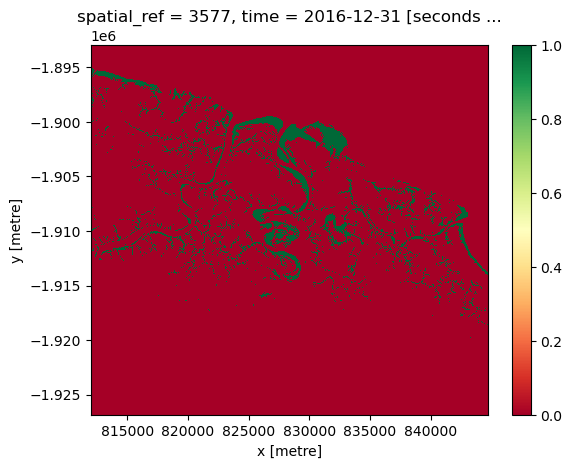

In [7]:
# Keep this one, its working fine


import numpy as np
import xarray as xr
from scipy.ndimage import generic_filter

# Define a function to compute the mode of an array
def mode_filter_func(values):
    mode_value = np.bincount(values.astype(int)).argmax()
    return mode_value

# Threshold definition based on the data exploration
mmri_threshold = 0
mndwi_threshold = -0.5
ndwi_threshold = -0.25
deltaMMRI_threshold = 0.15
distance_threshold = 480 # this is equivalent to 12 km

# Define exclusion masks
mmri_mask = ls_2016['MMRI'] < mmri_threshold
mndwi_mask_2016 = ls_2016['MNDWI'] > mndwi_threshold
ndwi_mask_2016 = ls_2016['NDWI'] < ndwi_threshold
distance_mask = ls_2016['distance_to_coastline'] < distance_threshold

# Combine exclusion masks using logical AND
exclusion_mask = mmri_mask & mndwi_mask_2016

# Define the inclusion mask
dmmri_mask_2016 = ls_2016['deltaMMRI'] > deltaMMRI_threshold

# Combine the exclusion and inclusion masks
combined_mask = (exclusion_mask | dmmri_mask_2016) & ndwi_mask_2016 & distance_mask

# Ensure combined_mask is a binary mask and convert to integer
combined_mask = combined_mask.astype(np.uint8)

# Plot the binary mask for verification
combined_mask.isel(time=0).plot(cmap='RdYlGn')

# Apply majority filter (mode filter) to the mask using generic_filter
filtered_mask = generic_filter(combined_mask, mode_filter_func, size=3)

# Ensure the filtered mask is binary
filtered_mask = (filtered_mask > 0).astype(np.uint8)

# Convert the numpy array back to an xarray DataArray and assign attributes
filtered_mask_da = xr.DataArray(
    filtered_mask,
    dims=combined_mask.dims,
    coords=combined_mask.coords,
    attrs=ls_2016.attrs
)

# Write the filtered mask to a GeoTIFF file
write_cog(
    geo_im=filtered_mask_da,
    fname='filtered_combined_mask_270524_v4e.tif',
    overwrite=True
)

# Reindexing the mask to align it with the dataset coordinates
aligned_mask = filtered_mask_da.reindex_like(ls_2016, method='nearest')

# Apply the aligned mask to the dataset
ls_2016_masked = ls_2016.where(aligned_mask, drop=False)


# Performing K-means classification

In [ ]:
# Define bands to use
bands = ['deltaNDVI',
         'nbart_blue',
         'nbart_green',
         'nbart_nir',
         'nbart_red',
         'nbart_swir_1',
         'nbart_swir_2',
         'NDVI_2015',
         'NDVI',
         'MNDWI',
         # 'dem_s',
         # 'dem_h'
        ]

# Flatten each band data and create a mask for valid pixels
pixels = np.column_stack([ls_2016_masked[band].values.flatten() for band in bands])
valid_pixels_mask = ~np.isnan(pixels).any(axis=1)  # Mask for rows where all elements are not NaN

# Standardize the features for valid pixels only
scaler = StandardScaler()
valid_pixels_scaled = scaler.fit_transform(pixels[valid_pixels_mask])

# Apply K-Means clustering to the valid pixels
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(valid_pixels_scaled)
valid_labels = kmeans.labels_

# Create an array to hold all labels, initializing with a value to indicate invalid/missing data
all_labels = np.full(pixels.shape[0], fill_value=-1)

# Place the valid labels in their original positions
all_labels[valid_pixels_mask] = valid_labels

# Reshape the labels to the original image's 2D shape
rows, cols = ls_2016_masked.dims['y'], ls_2016_masked.dims['x']  # Get the original dimensions
clustered_image = all_labels.reshape(rows, cols)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(clustered_image, cmap='viridis', interpolation='none')
plt.title('Clustered Image')
cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('Cluster Label')
plt.show()

# Convert the clustered_image ndarray into an xarray DataArray
clustered_da = xr.DataArray(
    data=clustered_image.astype(np.int16),
    dims=['y', 'x'],
    coords={
        'y': ls_2016_masked.coords['y'],
        'x': ls_2016_masked.coords['x']
    },
    name='clusters'
)

# Remove time dimension for applying the mask
if 'time' in clustered_da.dims and clustered_da['time'].size == 1:
    clustered_da = clustered_da.squeeze('time')  

# Reorder dimensions for applying the mask
if clustered_da.dims != ('y', 'x'):
    clustered_da = clustered_da.transpose('y', 'x')  

# Save the DataArray as a GeoTIFF
clustered_da.rio.write_crs('EPSG:3577', inplace=True)
output_tif_path = "./ls_2016_300524_v4f.tif"
clustered_da.rio.to_raster(output_tif_path, dtype=np.int16, compress='LZW')


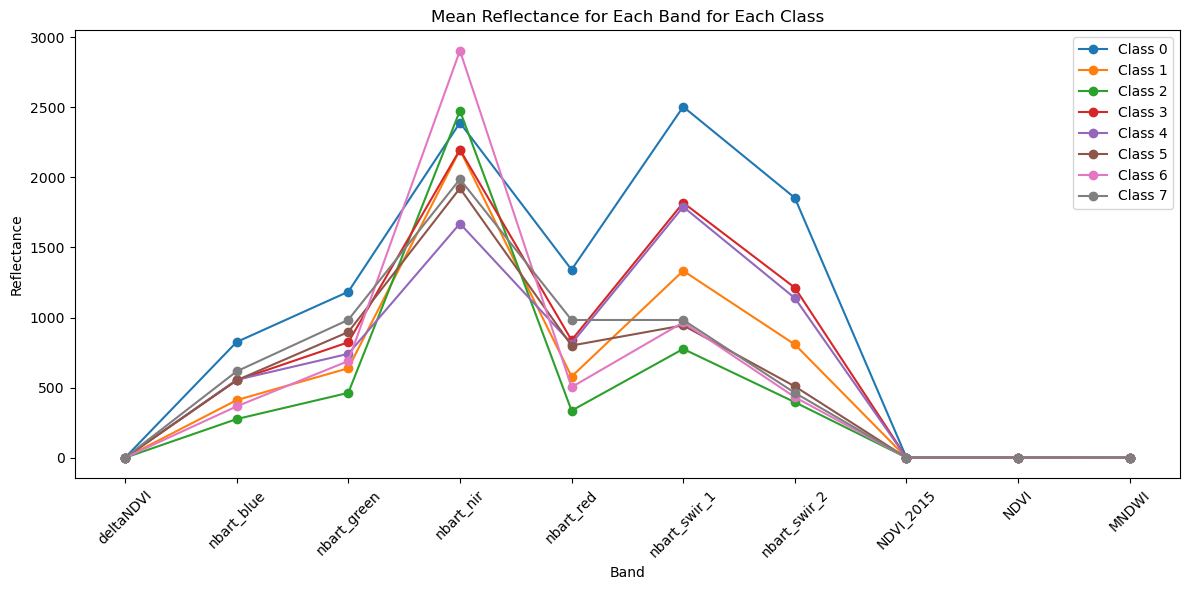

In [18]:
import numpy as np
import matplotlib.pyplot as plt

bands = ['deltaNDVI',
         'nbart_blue',
         'nbart_green',
         'nbart_nir',
         'nbart_red',
         'nbart_swir_1',
         'nbart_swir_2',
         'NDVI_2015',
         'NDVI',
         'MNDWI'
        ]
# Calculate mean reflectance for each band for each class
class_means = []
for i in range(8):  # Assuming 7 classes
    class_mask = (all_labels == i)
    class_pixels = pixels[class_mask]
    class_mean = np.mean(class_pixels, axis=0)
    class_means.append(class_mean)

# Plot each class's mean reflectance for each band
fig, ax = plt.subplots(figsize=(12, 6))
for i, class_mean in enumerate(class_means):
    ax.plot(bands, class_mean, label=f'Class {i}', marker='o')

ax.set_xlabel('Band')
ax.set_ylabel('Reflectance')
ax.set_title('Mean Reflectance for Each Band for Each Class')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Performing random forest classification

In [19]:
with rasterio.open('ls_2016_300524_v4f.tif') as src:
    labels_2016 = src.read(1)

# Flatten the labels
labels_2016_flat = labels_2016.flatten()

ds_2016 = ls_2016

features_2016 = np.column_stack([
                                ds_2016.nbart_blue.values.flatten(), 
                                ds_2016.nbart_green.values.flatten(), 
                                ds_2016.nbart_red.values.flatten(), 
                                ds_2016.nbart_nir.values.flatten(), 
                                ds_2016.nbart_swir_1.values.flatten(), 
                                ds_2016.nbart_swir_2.values.flatten(),
                                ls_2015.NDVI.values.flatten()
                                ])


### Training the model and evaluating

In [20]:
# # Test the best parameters

# # Filter out pixels with invalid data in either features or labels
# valid_mask = (~np.isnan(features_2016).any(axis=1)) & (labels_2016_flat != -1)

# features_valid = features_2016[valid_mask]
# labels_valid = labels_2016_flat[valid_mask]

# # Create a DataFrame for easier manipulation
# data = pd.DataFrame(features_valid)
# data['label'] = labels_valid

# # Initialize lists to store sampled data
# sampled_features = []
# sampled_labels = []

# # Loop through each unique category in the labels
# for category in data['label'].unique():
#     category_data = data[data['label'] == category]
    
#     # Randomly sample 1000 pixels for the current category
#     if len(category_data) > 1000:
#         category_sample = category_data.sample(n=1000, random_state=42)
#     else:
#         category_sample = category_data  # if less than 1000, take all pixels
    
#     sampled_features.append(category_sample.drop(columns='label').values)
#     sampled_labels.append(category_sample['label'].values)

# # Combine the sampled data
# sampled_features = np.vstack(sampled_features)
# sampled_labels = np.concatenate(sampled_labels)

# # Split the sampled data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(sampled_features, sampled_labels, test_size=0.3, random_state=42)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
# }

# # Initialize the classifier
# rf = RandomForestClassifier(random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# # Best parameters and best score
# print("Best Parameters: ", grid_search.best_params_)
# print("Best Score: ", grid_search.best_score_)

# # Validate the best model
# best_rf = grid_search.best_estimator_
# y_pred_val = best_rf.predict(X_val)

# print("Classification Report: \n", classification_report(y_val, y_pred_val))
# print("Confusion Matrix: \n", confusion_matrix(y_val, y_pred_val))


In [21]:
# Filter out pixels with invalid data in either features or labels
valid_mask = (~np.isnan(features_2016).any(axis=1)) & (labels_2016_flat != -1)

features_valid = features_2016[valid_mask]
labels_valid = labels_2016_flat[valid_mask]

# Create a DataFrame for easier manipulation
data = pd.DataFrame(features_valid)
data['label'] = labels_valid

# Initialize lists to store sampled data
sampled_features = []
sampled_labels = []

# Loop through each unique category in the labels
for category in data['label'].unique():
    category_data = data[data['label'] == category]
    
    # Randomly sample 800 pixels for the current category
    if len(category_data) > 1000:
        category_sample = category_data.sample(n=1000, random_state=42)
    else:
        category_sample = category_data  # if less than 800, take all
    
    sampled_features.append(category_sample.drop(columns='label').values)
    sampled_labels.append(category_sample['label'].values)

# Combine the sampled data
sampled_features = np.vstack(sampled_features)
sampled_labels = np.concatenate(sampled_labels)

# Split the sampled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(sampled_features, sampled_labels, test_size=0.3, random_state=42)

# Train the Random Forest Classifier
clf = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42)
clf.fit(X_train, y_train)

# Validate the model
y_pred_val = clf.predict(X_val)

print("Classification Report: \n", classification_report(y_val, y_pred_val))
print("Confusion Matrix: \n", confusion_matrix(y_val, y_pred_val))


Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       285
           1       0.93      0.91      0.92       266
           2       0.97      0.98      0.97       299
           3       0.93      0.93      0.93       318
           4       0.98      0.94      0.96       310
           5       0.93      0.95      0.94       313
           6       0.96      0.95      0.96       319
           7       0.94      0.99      0.97       188

    accuracy                           0.95      2298
   macro avg       0.95      0.95      0.95      2298
weighted avg       0.95      0.95      0.95      2298

Confusion Matrix: 
 [[282   0   0   1   1   0   0   1]
 [  0 243   5   5   0   5   8   0]
 [  0   2 292   0   0   1   4   0]
 [  7   6   0 295   4   6   0   0]
 [  2   5   0  13 290   0   0   0]
 [  1   3   0   4   1 296   0   8]
 [  0   2   4   0   0   7 304   2]
 [  0   0   0   0   0   2   0 186]]


#### Applying the model

In [ ]:
previous_year_ndvi = None
previous_mask = None

# Loop through the years of interest
for year in range(1987, 2024):
    query_landsat = {
        'x': (139.659678, 139.949658),
        'y': (-17.515088, -17.805069),
        'time': str(year),
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25),
        'group_by': 'solar_day'
    }

    try:
        # Load data using predefined function
        ds = load_ard(dc=dc, products=['ga_ls8c_ard_3', 'ga_ls7e_ard_3', 'ga_ls5t_ard_3'], min_gooddata=0.99, **query_landsat)
        if ds is None or len(ds.time) == 0:
            print(f"No data available for year {year}. Skipping...")
            continue
    except ValueError:
        print(f"Data for year {year} not found or does not meet quality threshold. Skipping...")
        continue

    # Resample dataset to yearly median values
    ds_resampled = ds.resample(time='1Y').median()

    # Calculate indices
    ds_resampled = calculate_indices(ds_resampled, index='NDVI', collection='ga_ls_3')
    ds_resampled = calculate_indices(ds_resampled, index='MNDWI', collection='ga_ls_3')
    ds_resampled = calculate_indices(ds_resampled, index='NDWI', collection='ga_ls_3')
    ds_resampled = calculate_indices(ds_resampled, index='WI', collection='ga_ls_3')


    # Calculate MMRI for the current year
    abs_NDVI = np.abs(ds_resampled['NDVI'].squeeze())
    abs_MNDWI = np.abs(ds_resampled['MNDWI'].squeeze())
    ds_resampled['MMRI'] = (abs_MNDWI - abs_NDVI) / (abs_MNDWI + abs_NDVI + 1e-10)

    # Calculate changes from the previous year
    if previous_year_ndvi is not None:
        ds_resampled['deltaNDVI'] = ds_resampled['NDVI'] - previous_year_ndvi['NDVI']
        ds_resampled['deltaMMRI'] = ds_resampled['MMRI'] - previous_year_ndvi['MMRI']

        # Stack all bands
    features_raw = np.column_stack([
        ds_resampled.nbart_blue.values.flatten(), 
        ds_resampled.nbart_green.values.flatten(), 
        ds_resampled.nbart_red.values.flatten(), 
        ds_resampled.nbart_nir.values.flatten(), 
        ds_resampled.nbart_swir_1.values.flatten(), 
        ds_resampled.nbart_swir_2.values.flatten(),
        ds_resampled.NDVI.values.flatten()
    ])
    
    if previous_year_ndvi is not None:
        features_raw = np.column_stack([
            ds_resampled.nbart_blue.values.flatten(), 
            ds_resampled.nbart_green.values.flatten(), 
            ds_resampled.nbart_red.values.flatten(), 
            ds_resampled.nbart_nir.values.flatten(), 
            ds_resampled.nbart_swir_1.values.flatten(), 
            ds_resampled.nbart_swir_2.values.flatten(),
            previous_year_ndvi['NDVI'].values.flatten()
        ])

    valid_pixels = ~np.isnan(features_raw).any(axis=1)
    features_valid = features_raw[valid_pixels]
    predicted_labels = clf.predict(features_valid)

    # Map predicted labels back to original grid shape
    original_shape = ds_resampled['nbart_blue'].squeeze().shape
    predicted_map = np.full(original_shape, -1, dtype=np.int8)  # Initialize with -1 for no data
    predicted_map.flat[valid_pixels] = predicted_labels

    # Convert to xarray DataArray for easy handling
    predicted_da = xr.DataArray(predicted_map, dims=['y', 'x'], coords={'y': ds_resampled.y, 'x': ds_resampled.x})
    
    # Defining thresholds
    ndvi_threshold = 0.3
    mndwi_threshold = -0.5
    ndwi_threshold = -0.25
    mmri_threshold = -0.2
    wi_threshold = -2.18
    deltaMMRI_threshold = 0.15
    
    
    # Define masks based on thresholds
    mmri_mask = ds_resampled['MMRI'] < mmri_threshold
    mndwi_mask = ds_resampled['MNDWI'] > mndwi_threshold
    ndvi_mask = ds_resampled['NDVI'] > ndvi_threshold
    ndwi_mask = ds_resampled['NDWI'] < ndwi_threshold
    wi_mask = ds_resampled['WI'] < wi_threshold
   
    if previous_mask is not None and 'deltaMMRI' in ds_resampled:
        dmmri_mask = ds_resampled['deltaMMRI'] > deltaMMRI_threshold
        combined_mask = ((previous_mask & dmmri_mask) | (mmri_mask & ndvi_mask)) & wi_mask & distance_mask
    else:
        combined_mask = (ndwi_mask & mmri_mask & ndvi_mask) & wi_mask & distance_mask # Fallback for the first year
    
    
    # Apply mask to the classified data
    final_classified_da = predicted_da.where(combined_mask, other=-1)  # -1 for no data
    
    # I was having issues exporting the data, this match the dimensions for exporting    
    # Ensure dimensions are correct
    if len(final_classified_da.dims) > 2:
        final_classified_da = final_classified_da.squeeze()  # This removes any singular dimensions

    # Check if dimensions need rearranging
    if final_classified_da.dims != ('y', 'x'):
        final_classified_da = final_classified_da.transpose('y', 'x')  # Reorder dimensions

    # Save the results as GeoTIFF
    final_classified_da.rio.write_crs(ds_resampled.crs, inplace=True)
    final_classified_da.rio.to_raster(f"./classification_result_v4f_{year}.tif")


    ### EXPORTING MASK
    if 'time' in combined_mask.dims and combined_mask.sizes['time'] == 1:
        combined_mask = combined_mask.isel(time=0)  # This selects the first index of 'time' dimension

    mask_da = xr.DataArray(combined_mask, dims=['y', 'x'], coords={'y': ds_resampled.y, 'x': ds_resampled.x})

    # Selecting the desired time dimension (to match to mask_da)
    ds_resampled = ds_resampled.isel(time=0)

    # Convert the boolean mask to uint8 (to open in ArcGIS as integer raster)
    mask_da = xr.DataArray(combined_mask.astype(np.uint8), dims=['y', 'x'], coords={'y': ds_resampled.y, 'x': ds_resampled.x})
    mask_da.rio.write_crs(ds_resampled.crs, inplace=True)

    # Set nodata value explicitly
    mask_da.rio.set_nodata(255, inplace=True)  # Use 255 as nodata for uint8 data

    # Now save it as a GeoTIFF, ensuring the dtype is set to uint8
    mask_da.rio.to_raster(f"./mask_v4f_{year}.tif", dtype='uint8')
        
    # Update the previous year data
    previous_year_ndvi = ds_resampled
    
    # Temporal link for dieback class
    previous_mask = mask_da

    print(f"Processed and saved data for year {year}.")


Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3
    ga_ls5t_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 3 out of 10 time steps with at least 99.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 3 time steps


#### Removing salt and pepper noise

In [ ]:
def majority_filter(pixel_values):
    pixel_values = pixel_values[~np.isnan(pixel_values)]
    if len(pixel_values) == 0:
        return np.nan
    else:
        return mode(pixel_values, axis=None)[0]

# Define the size of the neighborhood window
window_size = 3

for year in range(1987, 2024):
    file_path = f"./classification_result_v4f_{year}.tif"
    try:
        # Load the classified raster for the year
        da = rio.open_rasterio(file_path)
        
        # Extract the numpy array for processing
        predicted_map_year = da.values.squeeze()
        
        # Apply the majority filter
        filtered_map = generic_filter(predicted_map_year, function=majority_filter, size=window_size, mode='constant', cval=np.nan)
        
        # Convert the numpy array back to an xarray DataArray
        filtered_da = xr.DataArray(filtered_map, dims=['y', 'x'], coords={'y': da.y, 'x': da.x})
        
        # Assign the CRS from the original DataArray
        filtered_da.rio.write_crs(da.rio.crs, inplace=True)
        
        # Save the filtered result to a new GeoTIFF
        output_path = f"./filtered_result_v4f_{year}.tif"
        filtered_da.rio.to_raster(output_path)
        print(f"Processed and saved filtered raster for year {year} to {output_path}")
        
    except Exception as e:
        print(f"Error processing year {year}: {e}")


In [ ]:
for year in range(1987, 2024):
    file_path = f"./mask_v4f_{year}.tif"
    try:
        da = rio.open_rasterio(file_path)
        predicted_map_year = da.values.squeeze()
        filtered_map = generic_filter(predicted_map_year, function=majority_filter, size=window_size, mode='constant', cval=np.nan)
        filtered_da = xr.DataArray(filtered_map, dims=['y', 'x'], coords={'y': da.y, 'x': da.x})
        filtered_da.rio.write_crs(da.rio.crs, inplace=True)
        output_path = f"./filtered_mask_v4f_{year}.tif"
        filtered_da.rio.to_raster(output_path)
        print(f"Processed and saved filtered raster for year {year} to {output_path}")
    except Exception as e:
        print(f"Error processing year {year}: {e}")


# Comparing the model

#### Hay et al. (2005)
##### Methods for Monitoring the Abundance and Habitat of the Northern Australian Mud Crab <i>Scylla serrata</i>

###### This is not a direct comparison, as the classes are different, so I reclassify the <i>lr_filtered_140524_v4a_2000.tif</i> file to match to Hay et al. (2005).
#### Hay et al. (2005) reclassified data:
    Class 1: Closed Rhizophora
    Class 2: Closed Avicennia
    Class 3: Closed mixed / closed Ceriops
    Class 4: Open Avicennia

In [3]:
# Load mangrove classification for 2000 reclassified
with rasterio.open('reclassified_2000.tif') as src:
    classification_2000 = src.read(1)

# Flatten the labels
classification_2000_flat = classification_2000.flatten()

# Load Hay et al. (2000) classification
with rasterio.open('reclassified_hay2005.tif') as src:
    hay_2000 = src.read(1)
    
hay_2000_flat = hay_2000.flatten()

# Make the two datasets merge properly
min_length = min(len(hay_2000_flat), len(classification_2000_flat))

# Trim the arrays to the minimum length
hay_2000_flat_trimmed = hay_2000_flat[:min_length]
classification_2000_flat_trimmed = classification_2000_flat[:min_length]

# Compute the confusion matrix and accuracy score
conf_matrix = confusion_matrix(hay_2000_flat_trimmed, classification_2000_flat_trimmed)
overall_accuracy = accuracy_score(hay_2000_flat_trimmed, classification_2000_flat_trimmed)

print("Confusion Matrix:\n", conf_matrix)
print("Overall Accuracy:", overall_accuracy)


Confusion Matrix:
 [[      0       0       0       0       0       0]
 [   2084       2      18       9      34       0]
 [  24872     186     199     104     121       0]
 [  61807     535     819     358     303       0]
 [   8756      47      61      28      57       0]
 [1412198   11478   14870    6981    7529       0]]
Overall Accuracy: 0.00039653520923669546


In [4]:
kappa_score = cohen_kappa_score(hay_2000_flat_trimmed, classification_2000_flat_trimmed)
kappa_score


-1.0617906230026009e-05

In [ ]:
# # AUC
# # Convert true class labels to one-hot encoded format
# n_classes = len(np.unique(hay_2000_flat_trimmed))
# true_labels_one_hot = np.eye(n_classes)[hay_2000_flat_trimmed]

# # Compute the AUC for each class
# auc_scores = roc_auc_score(true_labels_one_hot, predicted_probs, average=None)

# # Compute the average AUC
# average_auc = np.mean(auc_scores)

# print("AUC Scores for each class:", auc_scores)
# print("Average AUC:", average_auc)

#### Duke et al. (2017)
##### Large-scale dieback of mangroves in Australia’s Gulf of Carpentaria: a severe ecosystem response, coincidental with an unusually extreme weather event

###### This is a direct comparison of mangrove dieback

In [ ]:
# Load mangrove dieback classification for 2016
with rasterio.open('dieback_2016_v4b.tif') as src:
    dieback_2016 = src.read(1)

# Flatten the labels
dieback_2016_flat = dieback_2016.flatten()
dieback_2016_flat

# Load Duke et al. (2017) classification for 2016
with rasterio.open('dieback_2016_duke2017.tif') as src:
    duke_2016 = src.read(1)
    
duke_2016_flat = duke_2016.flatten()
duke_2016_flat

min_length = min(len(duke_2016_flat), len(dieback_2016_flat))

# Trim the arrays to the minimum length
duke_2016_flat_trimmed = duke_2016_flat[:min_length]
dieback_2016_flat_trimmed = dieback_2016_flat[:min_length]

# Then compute the confusion matrix and accuracy score
conf_matrix = confusion_matrix(duke_2016_flat_trimmed, dieback_2016_flat_trimmed)
overall_accuracy = accuracy_score(duke_2016_flat_trimmed, dieback_2016_flat_trimmed)

print("Confusion Matrix:\n", conf_matrix)
print("Overall Accuracy:", overall_accuracy)


In [ ]:
kappa_score = cohen_kappa_score(duke_2016_flat_trimmed, dieback_2016_flat_trimmed)
kappa_score


# Exporting data

In [ ]:
# # Loop over each year
# start_year = 1987
# end_year = 2023
# years = range(start_year, end_year + 1)

# previous_year_ndvi = None

# query_ls = {
#     'x': (139.659678, 139.949658),
#     'y': (-17.515088, -17.805069),
#     'output_crs': 'EPSG:3577',
#     'resolution': (-25, 25),
#     'group_by': 'solar_day'
# }

# for year in years:
#     query_ls['time'] = (f'{year}-01-01', f'{year}-12-31')
    
#     ds = load_ard(dc=dc, products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], min_gooddata=0.99, **query_ls)
    
#     # Check if the dataset is empty and skip if it is
#     if ds is None or ds.time.size == 0:
#         print(f'No data available for {year}, skipping.')
#         continue
    
#     yearly_median = ds.resample(time='1Y').median()
    
#     # Calculate NDVI and NDWI, and add them to the dataset
#     ndvi = calculate_indices(yearly_median, index='NDVI', collection='ga_ls_3')
#     yearly_median['NDVI'] = ndvi['NDVI']
#     ndwi = calculate_indices(yearly_median, index='NDWI', collection='ga_ls_3')
#     yearly_median['NDWI'] = ndwi['NDWI']
#     mndwi = calculate_indices(yearly_median, index='MNDWI', collection='ga_ls_3')
#     yearly_median['MNDWI'] = mndwi['MNDWI']
    
#     # MMRI Calculation for the current year
#     abs_NDVI = np.abs(yearly_median['NDVI'].squeeze())
#     abs_MNDWI = np.abs(yearly_median['MNDWI'].squeeze())
#     yearly_median['MMRI'] = (abs_MNDWI - abs_NDVI) / (abs_MNDWI + abs_NDVI)

#     if previous_year_ndvi is not None:
#         delta_ndvi = yearly_median['NDVI'] - previous_year_ndvi['NDVI']
#         delta_mmri = yearly_median['MMRI'] - previous_year_ndvi['MMRI']
#         yearly_median['deltaNDVI'] = delta_ndvi
#         yearly_median['deltaMMRI'] = delta_mmri
#         write_cog(geo_im=yearly_median['deltaNDVI'], fname=f'deltaNDVI_{year}.tif', overwrite=True)
#         write_cog(geo_im=yearly_median['deltaMMRI'], fname=f'deltaMMRI_{year}.tif', overwrite=True)

#     # Save NDVI, NDWI, MNDWI
#     write_cog(geo_im=yearly_median['NDVI'], fname=f'NDVI_{year}.tif', overwrite=True)
#     write_cog(geo_im=yearly_median['NDWI'], fname=f'NDWI_{year}.tif', overwrite=True)
#     write_cog(geo_im=yearly_median['MNDWI'], fname=f'MNDWI_{year}.tif', overwrite=True)
#     write_cog(geo_im=yearly_median['MMRI'], fname=f'MMRI_{year}.tif', overwrite=True)
    
#     previous_year_ndvi = yearly_median

#     print(f'Processed and saved data for {year}')


In [ ]:
# for year in range(1987, 2024):
#     query_fc = {
#         'x': (139.659678, 139.949658),
#         'y': (-17.515088, -17.805069),
#         'time': f'{year}',
#         'output_crs': 'EPSG:32754',
#         'resolution': (-30, 30),
#         'group_by': 'solar_day'
#     }

#     try:
#         # Load DEA Fractional Cover data for the specified year
#         fc = dc.load(product='ga_ls_fc_3',
#                      measurements=['bs', 'pv', 'npv'],
#                      **query_fc)
#         fc_resampled = fc.resample(time='1Y').median()

        
#         # Check if there is data for the current year
#         if fc_resampled is None or 'time' not in fc_resampled or len(fc_resampled.time) == 0:
#             print(f"No data available for year {year}. Skipping...")
#             continue

#         # Save each fractional cover component as a GeoTIFF
#         for measurement in ['bs', 'pv', 'npv']:
#             fc_measurement = fc_resampled[measurement]
#             filename = f'./{measurement}_{year}.tif'
#             fc_measurement.rio.to_raster(filename)
#             print(f"Saved {measurement} image for {year} as {filename}")

#     except ValueError as e:
#         print(f"Data for year {year} not found or does not meet quality threshold. Skipping...")
#     except Exception as e:
#         print(f"Error in processing year {year}: {e}")
        

In [1]:
import pandas as pd
import numpy as np
import rioxarray
from rasterio.errors import RasterioIOError

combined_data = pd.DataFrame(columns=['Year', 'Class', 'NDVI', 'NDWI', 'MNDWI', 'bs', 'pv', 'npv', 'PixelID'])

years = range(1987, 2024)

for year in years:
    paths = {
        "classified": f"./filtered_result_v4f_{year}.tif",
        "ndvi": f"./NDVI_{year}.tif",
        "ndwi": f"./NDWI_{year}.tif",
        "mndwi": f"./MNDWI_{year}.tif",
        "bs": f"./bs_{year}.tif",
        "pv": f"./pv_{year}.tif",
        "npv": f"./npv_{year}.tif"
    }
    
    data_arrays = {}
    valid_data = True
    
    for key, path in paths.items():
        try:
            data_array = rioxarray.open_rasterio(path)
            if "nrows" not in locals() or "ncols" not in locals():
                nrows, ncols = data_array.shape[1], data_array.shape[2]
            if key in ['bs', 'pv', 'npv']:
                data_array = data_array.rio.reproject_match(rioxarray.open_rasterio(paths['classified']))
            data_arrays[key] = data_array.squeeze().values.flatten()
        except (FileNotFoundError, RasterioIOError):
            print(f"Data for {year} not found ({key}). Filling with NaNs...")
            if 'nrows' in locals() and 'ncols' in locals():
                data_arrays[key] = np.full((nrows * ncols,), np.nan)
            else:
                valid_data = False
                break
    
    if not valid_data:
        continue
    
    # Ensure classified data is available, otherwise skip the year
    if np.all(np.isnan(data_arrays["classified"])):
        print(f"Classified data for {year} not found. Skipping year...")
        continue
    
    row_indices, col_indices = np.divmod(np.arange(nrows * ncols), ncols)
    pixel_ids = ["R" + str(row) + "_C" + str(col) for row, col in zip(row_indices, col_indices)]
    
    valid_mask = ~np.isnan(data_arrays["ndvi"]) & (data_arrays["classified"] >= 0)
    class_mask = data_arrays["classified"] != -1
    combined_mask = valid_mask & class_mask
    
    # Check for mask and data array shape mismatch
    if len(combined_mask) != len(data_arrays["classified"]):
        print(f"Mask length {len(combined_mask)} does not match data length {len(data_arrays['classified'])} for year {year}")
        continue
    
    year_data = pd.DataFrame({
        'Year': year,
        'Class': data_arrays["classified"][combined_mask],
        'NDVI': data_arrays["ndvi"][combined_mask],
        'NDWI': data_arrays["ndwi"][combined_mask],
        'MNDWI': data_arrays["mndwi"][combined_mask],
        'bs': data_arrays["bs"][combined_mask],
        'pv': data_arrays["pv"][combined_mask],
        'npv': data_arrays["npv"][combined_mask],
        'PixelID': np.array(pixel_ids)[combined_mask]
    })
    
    combined_data = pd.concat([combined_data, year_data], ignore_index=True)

# Write the combined data to a CSV file
combined_data.to_csv('pixel_data_300524_v4f.csv', index=False)

print("Data extraction and CSV writing complete.")


/tmp/ipykernel_94/3765099158.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_data = pd.concat([combined_data, year_data], ignore_index=True)


Data for 2012 not found (classified). Filling with NaNs...
Data for 2012 not found (ndvi). Filling with NaNs...
Data for 2012 not found (ndwi). Filling with NaNs...
Data for 2012 not found (mndwi). Filling with NaNs...
Data for 2012 not found (bs). Filling with NaNs...
Data for 2012 not found (pv). Filling with NaNs...
Data for 2012 not found (npv). Filling with NaNs...
Classified data for 2012 not found. Skipping year...
Data extraction and CSV writing complete.


In [6]:
import pandas as pd
import numpy as np
import rioxarray
from rasterio.errors import RasterioIOError
from affine import Affine

combined_data = pd.DataFrame(columns=['Year', 'Class', 'NDVI', 'NDWI', 'MNDWI', 'bs', 'pv', 'npv', 'PixelID', 'Longitude', 'Latitude'])

years = range(1987, 2024)

for year in years:
    paths = {
        "classified": f"./filtered_result_v4f_{year}.tif",
        "ndvi": f"./NDVI_{year}.tif",
        "ndwi": f"./NDWI_{year}.tif",
        "mndwi": f"./MNDWI_{year}.tif",
        "bs": f"./bs_{year}.tif",
        "pv": f"./pv_{year}.tif",
        "npv": f"./npv_{year}.tif"
    }
    
    data_arrays = {}
    valid_data = True
    affine_transform = None
    
    for key, path in paths.items():
        try:
            print(f"Attempting to open {path} for year {year} ({key})...")
            data_array = rioxarray.open_rasterio(path)
            print(f"Opened {path} successfully.")
            if key == "classified":
                affine_transform = data_array.rio.transform()
                print(f"Affine transform for {year}: {affine_transform}")
            if "nrows" not in locals() or "ncols" not in locals():
                nrows, ncols = data_array.shape[1], data_array.shape[2]
            if key in ['bs', 'pv', 'npv']:
                data_array = data_array.rio.reproject_match(rioxarray.open_rasterio(paths['classified']))
            data_arrays[key] = data_array.squeeze().values.flatten()
        except (FileNotFoundError, RasterioIOError):
            print(f"Data for {year} not found ({key}). Filling with NaNs...")
            if 'nrows' in locals() and 'ncols' in locals():
                data_arrays[key] = np.full((nrows * ncols,), np.nan)
            else:
                valid_data = False
                break
    
    if not valid_data:
        continue
    
    # Ensure classified data is available, otherwise skip the year
    if np.all(np.isnan(data_arrays["classified"])):
        print(f"Classified data for {year} not found. Skipping year...")
        continue
    
    if affine_transform is None:
        print(f"Affine transform for {year} not found. Skipping year...")
        continue
    
    row_indices, col_indices = np.divmod(np.arange(nrows * ncols), ncols)
    pixel_ids = ["R" + str(row) + "_C" + str(col) for row, col in zip(row_indices, col_indices)]
    
    valid_mask = ~np.isnan(data_arrays["ndvi"]) & (data_arrays["classified"] >= 0)
    class_mask = data_arrays["classified"] != -1
    combined_mask = valid_mask & class_mask
    
    # Check for mask and data array shape mismatch
    if len(combined_mask) != len(data_arrays["classified"]):
        print(f"Mask length {len(combined_mask)} does not match data length {len(data_arrays['classified'])} for year {year}")
        continue
    
    # Calculate the coordinates using the affine transform
    lon, lat = zip(*[affine_transform * (col, row) for row, col in zip(row_indices[combined_mask], col_indices[combined_mask])])
    
    year_data = pd.DataFrame({
        'Year': year,
        'Class': data_arrays["classified"][combined_mask],
        'NDVI': data_arrays["ndvi"][combined_mask],
        'NDWI': data_arrays["ndwi"][combined_mask],
        'MNDWI': data_arrays["mndwi"][combined_mask],
        'bs': data_arrays["bs"][combined_mask],
        'pv': data_arrays["pv"][combined_mask],
        'npv': data_arrays["npv"][combined_mask],
        'PixelID': np.array(pixel_ids)[combined_mask],
        'Longitude': lon,
        'Latitude': lat
    })
    
    combined_data = pd.concat([combined_data, year_data], ignore_index=True)

# Write the combined data to a CSV file
combined_data.to_csv('pixel_data_300524_v4f.csv', index=False)

print("Data extraction and CSV writing complete.")


Attempting to open ./filtered_result_v4f_1987.tif for year 1987 (classified)...
Opened ./filtered_result_v4f_1987.tif successfully.
Affine transform for 1987: | 25.00, 0.00, 812000.00|
| 0.00,-25.00,-1892950.00|
| 0.00, 0.00, 1.00|
Attempting to open ./NDVI_1987.tif for year 1987 (ndvi)...
Opened ./NDVI_1987.tif successfully.
Attempting to open ./NDWI_1987.tif for year 1987 (ndwi)...
Opened ./NDWI_1987.tif successfully.
Attempting to open ./MNDWI_1987.tif for year 1987 (mndwi)...
Opened ./MNDWI_1987.tif successfully.
Attempting to open ./bs_1987.tif for year 1987 (bs)...
Opened ./bs_1987.tif successfully.
Attempting to open ./pv_1987.tif for year 1987 (pv)...
Opened ./pv_1987.tif successfully.
Attempting to open ./npv_1987.tif for year 1987 (npv)...
Opened ./npv_1987.tif successfully.


/tmp/ipykernel_94/1077271583.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_data = pd.concat([combined_data, year_data], ignore_index=True)


Attempting to open ./filtered_result_v4f_1988.tif for year 1988 (classified)...
Opened ./filtered_result_v4f_1988.tif successfully.
Affine transform for 1988: | 25.00, 0.00, 812000.00|
| 0.00,-25.00,-1892950.00|
| 0.00, 0.00, 1.00|
Attempting to open ./NDVI_1988.tif for year 1988 (ndvi)...
Opened ./NDVI_1988.tif successfully.
Attempting to open ./NDWI_1988.tif for year 1988 (ndwi)...
Opened ./NDWI_1988.tif successfully.
Attempting to open ./MNDWI_1988.tif for year 1988 (mndwi)...
Opened ./MNDWI_1988.tif successfully.
Attempting to open ./bs_1988.tif for year 1988 (bs)...
Opened ./bs_1988.tif successfully.
Attempting to open ./pv_1988.tif for year 1988 (pv)...
Opened ./pv_1988.tif successfully.
Attempting to open ./npv_1988.tif for year 1988 (npv)...
Opened ./npv_1988.tif successfully.
Attempting to open ./filtered_result_v4f_1989.tif for year 1989 (classified)...
Opened ./filtered_result_v4f_1989.tif successfully.
Affine transform for 1989: | 25.00, 0.00, 812000.00|
| 0.00,-25.00,-1892